In [182]:
import pandas as pd
import datetime

#Abre os bancos de dados necessários
pop = pd.read_csv('base_csv/pop2020.csv')
io = pd.read_csv('base_csv/caso_full.csv')

In [183]:
#Arruma os nomes das colunas para realizar o merge
pop.rename(columns={'Total':'total_inhabitants','Armenor':'city_ibge_code'}, inplace = True)

In [184]:
#Filtra somente os dados do último dia das semanas epidemiológicas
dates = ['2020-02-29', '2020-03-07', '2020-03-14','2020-03-21',
         '2020-03-28', '2020-04-04', '2020-04-11', '2020-04-18',
         '2020-04-25', '2020-05-02', '2020-05-09', '2020-05-16',
         '2020-05-23', '2020-05-30', '2020-06-06', '2020-06-13',
         '2020-06-20', '2020-06-27', '2020-07-04', '2020-07-11',
         '2020-07-18', '2020-07-25', '2020-08-01','2020-08-08',
         '2020-08-15','2020-08-22','2020-08-29','2020-09-05',
         '2020-09-12','2020-09-19']

datesDF = pd.DataFrame(dates,columns=['date'])

select_for_dates = pd.merge(io,datesDF, how = 'inner')

#Arruma o nome das colunas
select_for_dates.rename(columns={'date':'week_last_day'}, inplace = True)


In [185]:
#Classifica os estados por macro regiões
def region(x):
    regions = {
        'norte':['AM','RR','AP','PA','TO','RO','AC'],
        'nordeste':['MA','PI','CE','RN','PE','PB','SE','AL','BA'],
        'centro-oeste':['MT','MS','GO','DF'],
        'sudeste':['MG','SP','RJ','ES'],
        'sul':['PR','RS','SC']       
    }
    for k,v in regions.items():
        if x['state'] in v:
            return k
    
select_for_dates['region'] = select_for_dates.apply(region,axis=1)

In [186]:
#Cria uma coluna com a sigla de cada estado e uma com a região.
states_list = {'ACRE':'AC','ALAGOAS':'AL','AMAPÁ':'AP','AMAZONAS':'AM',
               'BAHIA':'BA','CEARÁ':'CE','ESPÍRITO SANTO':'ES','GOIÁS':'GO',
               'MARANHÃO':'MA','MATO GROSSO':'MT','MATO GROSSO DO SUL':'MS',
               'MINAS GERAIS':'MG','PARÁ':'PA','PARAÍBA':'PB','PARANÁ':'PR',
               'PERNAMBUCO':'PE','PIAUÍ':'PI','RIO DE JANEIRO':'RJ',
               'RIO GRANDE DO NORTE':'RN','RIO GRANDE DO SUL':'RS','RONDÔNIA':'RO',
               'RORAIMA':'RR','SANTA CATARINA':'SC','SÃO PAULO':'SP','SERGIPE':'SE',
               'TOCANTINS':'TO','DISTRITO FEDERAL':'DF'}
pop['state']=pop['ARmaior'].apply(lambda x: states_list[x])
pop['region']=pop.apply(region,axis=1)

In [187]:
#Seleciona o df de população para cálculo por cidades
pop_cities = pop[['city_ibge_code','total_inhabitants']].copy()
pop_cities['city_ibge_code'] = pop_cities['city_ibge_code'].astype('int')

In [188]:
#Seleciona o df de população para cálculo por estados
pop_states = pop[['state','total_inhabitants']].copy()
pop_states = pop_states.groupby(pop_states['state']).sum().reset_index()

In [189]:
#Seleciona o df de população para cálculo por regiões
pop_region = pop[['region','total_inhabitants']].copy()
pop_region = pop_region.groupby(pop_region['region']).sum().reset_index()

In [190]:
#Coloca o total da população das cidades no df selecionado por datas
cities_df = pd.merge(select_for_dates,pop_cities, how ='inner')

In [191]:
#Coloca o total da população dos estados no df selecionado por datas
states_df = pd.merge(select_for_dates,pop_states, how ='inner')

In [192]:
#Seleciona apenas os estados no df de estados
states_df = states_df[states_df['place_type']=='state']

In [193]:
#Seleciona somente os estados no df de regiões
regions_df = select_for_dates.copy()
regions_df = regions_df[regions_df['place_type']=='state']


In [194]:
#Encontrar o valor dos novos casoso por semana, para cidades, estados e regiões
last_place = 0
last_num = 0 

def get_num(x):
    global last_num, last_place
    if last_place == x['city_ibge_code']:
        current = x['last_available_confirmed']-last_num
        last_num = x['last_available_confirmed']
        return current
    else:
        last_place = x['city_ibge_code']
        last_num = 0
        return get_num(x)


cities_df = cities_df.sort_values(by=['city_ibge_code','week_last_day']).copy()
cities_df['new_week_cases'] = cities_df.apply(get_num , axis=1)

states_df = states_df.sort_values(by=['city_ibge_code','week_last_day']).copy()
states_df['new_week_cases'] = states_df.apply(get_num , axis=1)

regions_df = regions_df.sort_values(by=['city_ibge_code','week_last_day']).copy()
regions_df['new_week_cases'] = regions_df.apply(get_num , axis=1)


In [195]:
#Encontrar o valor dos novos óbitos por semana

last_place = 0
last_num = 0 

def get_num(x):
    global last_num, last_place
    if last_place == x['city_ibge_code']:
        current = x['last_available_deaths']-last_num
        last_num = x['last_available_deaths']
        return current
    else:
        last_place = x['city_ibge_code']
        last_num = 0
        return get_num(x)



cities_df['new_week_deaths'] = cities_df.apply(get_num , axis=1)
states_df['new_week_deaths'] = states_df.apply(get_num , axis=1)
regions_df['new_week_deaths'] = regions_df.apply(get_num , axis=1)


In [196]:
#DF por cidades
cities_df= cities_df.copy().reset_index()
cities_df = cities_df[['region','state','city','city_ibge_code','week_last_day','epidemiological_week','total_inhabitants','last_available_confirmed','last_available_deaths','new_week_cases','new_week_deaths']].copy()

In [197]:
#DF por estado
states_df = states_df[['state','city_ibge_code','week_last_day','epidemiological_week','total_inhabitants','last_available_confirmed','last_available_deaths','new_week_cases','new_week_deaths']].copy().reset_index()


In [198]:
#DF por macro região 
regions_df = regions_df.groupby(['region','epidemiological_week','week_last_day']).sum().reset_index()
regions_df = pd.merge(regions_df,pop_region, how = 'inner')
regions_df = regions_df[['region','week_last_day','epidemiological_week','total_inhabitants','last_available_confirmed','last_available_deaths','new_week_cases','new_week_deaths']].copy()

In [199]:
#DF Brasil
brazil_df = states_df.groupby(['epidemiological_week','week_last_day']).sum().reset_index()
brazil_df = brazil_df[['week_last_day','epidemiological_week','last_available_confirmed','last_available_deaths','new_week_cases','new_week_deaths']].copy()
#Corrige o valor da população total
total_inhabitants = pop['total_inhabitants'].sum()
brazil_df['total_inhabitants']= brazil_df.apply(lambda x: total_inhabitants,axis=1)
brazil_df = brazil_df[['week_last_day','epidemiological_week','total_inhabitants','last_available_confirmed','last_available_deaths','new_week_cases','new_week_deaths']].copy()


In [200]:
#---------------------Indicadores ---------------------

In [201]:
#Indicador de Casos e Óbitos acumulados,por semana epidemiológica, já esta no DF, 
#respesctivamente nas colunas last_available_confirmed e last_available_deaths

In [202]:
#Novos Casos e Novos Óbitos, por semana epidemiológica, já está no DF,
#respesctivamente nas colunas new_week_cases e new_week_deaths

In [203]:
def indicators_state_city(data_frame):
    #Prevalência
    data_frame['prevalence'] = data_frame.apply(lambda x:x['last_available_confirmed']*100000/x['total_inhabitants'] , axis=1)
    
    #Indicador Mortalidade
    data_frame['mortality'] = data_frame.apply(lambda x:x['last_available_deaths']*100000/x['total_inhabitants'] , axis=1)
    
    #Indicador de Letalidade em %
    def lethality(x):
        if x['last_available_confirmed']==0:
            return 0
        else:
            return x['last_available_deaths']/x['last_available_confirmed']*100
    data_frame['lethality'] = data_frame.apply(lethality, axis=1)
    
    #Incidência de novos casos
    data_frame['incidence_cases'] = data_frame.apply(lambda x:x['new_week_cases']*100000/x['total_inhabitants'] , axis=1)
    
    #Incidência de novos óbitos
    data_frame['incidence_deaths'] = data_frame.apply(lambda x:x['new_week_deaths']*100000/x['total_inhabitants'] , axis=1)

    #Indicador Fator de Crescimento  dos casos
    last_number_cases=0
    last_place_cases = ''

    def get_FC_cases(x):
        nonlocal last_number_cases, last_place_cases
        
        if last_place_cases != x['city_ibge_code']:
            last_place_cases = x['city_ibge_code']
            last_number_cases = x['new_week_cases']
            return 0  
        elif last_number_cases ==0:
            last_number_cases = x['new_week_cases']
            return 0
            
        else:
            fc= x['new_week_cases']/last_number_cases
            last_number_cases = x['new_week_cases']
            return fc

    data_frame['cases_growth_factor'] = data_frame.apply(get_FC_cases, axis=1)

    #Indicador Fator de Crescimento  dos óbitos
    last_number_deaths=0
    last_place_deaths = ''
    

    def get_FC_deaths(x):
        nonlocal last_number_deaths, last_place_deaths
        
        if last_place_deaths != x['city_ibge_code']:
            last_place_deaths = x['city_ibge_code']
            last_number_deaths = x['new_week_deaths']
            return 0 
        elif last_number_deaths ==0:
            last_number_deaths = x['new_week_deaths']
            return 0
        
        else:
            fc= x['new_week_deaths']/last_number_deaths
            last_number_deaths = x['new_week_deaths']
            return fc

    data_frame['deaths_growth_factor'] = data_frame.apply(get_FC_deaths, axis=1)

In [204]:
def indicators_region(data_frame):
    #Prevalência
    data_frame['prevalence'] = data_frame.apply(lambda x:x['last_available_confirmed']*100000/x['total_inhabitants'] , axis=1)
    
    #Indicador Mortalidade
    data_frame['mortality'] = data_frame.apply(lambda x:x['last_available_deaths']*100000/x['total_inhabitants'] , axis=1)
    
    #Indicador de Letalidade em %
    def lethality(x):
        if x['last_available_confirmed']==0:
            return 0
        else:
            return x['last_available_deaths']/x['last_available_confirmed']*100
    data_frame['lethality'] = data_frame.apply(lethality, axis=1)
    
    #Incidência de novos casos
    data_frame['incidence_cases'] = data_frame.apply(lambda x:x['new_week_cases']*100000/x['total_inhabitants'] , axis=1)
    
    #Incidência de novos óbitos
    data_frame['incidence_deaths'] = data_frame.apply(lambda x:x['new_week_deaths']*100000/x['total_inhabitants'] , axis=1)

    #Indicador Fator de Crescimento  dos casos
    last_number_cases=0
    last_place_cases = ''

    def get_FC_cases(x):
        nonlocal last_number_cases, last_place_cases
        
        if last_place_cases != x['region']:
            last_place_cases = x['region']
            last_number_cases = x['new_week_cases']
            return 0  
        elif last_number_cases ==0:
            last_number_cases = x['new_week_cases']
            return 0
            
        else:
            fc= x['new_week_cases']/last_number_cases
            last_number_cases = x['new_week_cases']
            return fc

    data_frame['cases_growth_factor'] = data_frame.apply(get_FC_cases, axis=1)

    #Indicador Fator de Crescimento  dos óbitos
    last_number_deaths=0
    last_place_deaths = ''
    

    def get_FC_deaths(x):
        nonlocal last_number_deaths, last_place_deaths
        
        if last_place_deaths != x['region']:
            last_place_deaths = x['region']
            last_number_deaths = x['new_week_deaths']
            return 0 
        elif last_number_deaths ==0:
            last_number_deaths = x['new_week_deaths']
            return 0
        
        else:
            fc= x['new_week_deaths']/last_number_deaths
            last_number_deaths = x['new_week_deaths']
            return fc

    data_frame['deaths_growth_factor'] = data_frame.apply(get_FC_deaths, axis=1)

In [205]:
def indicators_brazil(data_frame):
    #Prevalência
    data_frame['prevalence'] = data_frame.apply(lambda x:x['last_available_confirmed']*100000/x['total_inhabitants'] , axis=1)
    
    #Indicador Mortalidade
    data_frame['mortality'] = data_frame.apply(lambda x:x['last_available_deaths']*100000/x['total_inhabitants'] , axis=1)
    
    #Indicador de Letalidade em %
    def lethality(x):
        if x['last_available_confirmed']==0:
            return 0
        else:
            return x['last_available_deaths']/x['last_available_confirmed']*100
    data_frame['lethality'] = data_frame.apply(lethality, axis=1)
    
    #Incidência de novos casos
    data_frame['incidence_cases'] = data_frame.apply(lambda x:x['new_week_cases']*100000/x['total_inhabitants'] , axis=1)
    
    #Incidência de novos óbitos
    data_frame['incidence_deaths'] = data_frame.apply(lambda x:x['new_week_deaths']*100000/x['total_inhabitants'] , axis=1)

    #Indicador Fator de Crescimento  dos casos
    last_number_cases=0

    def get_FC_cases(x):
        nonlocal last_number_cases
        if last_number_cases ==0:
            last_number_cases = x['new_week_cases']
            return 0
        else:
            fc= x['new_week_cases']/last_number_cases
            last_number_cases = x['new_week_cases']
            return fc

    data_frame['cases_growth_factor'] = data_frame.apply(get_FC_cases, axis=1)

    #Indicador Fator de Crescimento  dos óbitos
    last_number_deaths=0
    

    def get_FC_deaths(x):
        nonlocal last_number_deaths
        if last_number_deaths ==0:
            last_number_deaths = x['new_week_deaths']
            return 0
        
        else:
            fc= x['new_week_deaths']/last_number_deaths
            last_number_deaths = x['new_week_deaths']
            return fc

    data_frame['deaths_growth_factor'] = data_frame.apply(get_FC_deaths, axis=1)

In [206]:
#Calcula os indicadores
indicators_region(regions_df)
indicators_brazil(brazil_df)
indicators_state_city(cities_df)
indicators_state_city(states_df)


In [207]:
c_df = cities_df.copy()
tp2 = c_df[c_df['city'] == "aaa"].copy()
cities = list(c_df.city.unique())
date = {}
dia = datetime.timedelta(days=7)
for ct in cities:
    week = c_df[c_df['city'] == ct]['epidemiological_week'].min()
    tp1 = c_df[c_df['city'] == ct][c_df['epidemiological_week']==week].copy()
    wld = list(tp1.week_last_day.values)[0]
    wld = datetime.datetime.strptime(wld,"%Y-%m-%d")
    wld = wld-dia
    wld = wld.isoformat().split('T')[0]
    tp1.week_last_day = wld
    week = week - 1
    tp1.epidemiological_week = week
    tp1.new_week_cases = 0
    tp1.new_week_deaths = 0
    tp1.last_available_confirmed = 0
    tp1.last_available_deaths = 0
    tp1.prevalence = 0
    tp1.mortality = 0
    tp1.lethality = 0
    tp1.incidence_cases = 0
    tp1.cases_growth_factor = 0
    tp1.deaths_growth_factor = 0
    while week >9:
        tp = tp1[-1:].copy()
        wld = list(tp.week_last_day.values)[0]
        wld = datetime.datetime.strptime(wld,"%Y-%m-%d")
        wld = wld-dia
        wld = wld.isoformat().split('T')[0]
        tp.week_last_day = wld
        week = week-1
        tp.epidemiological_week = week
        tp1 = tp1.append(tp,ignore_index=True)
    tp2 = tp2.append(tp1)

In [208]:
cities_df = cities_df.append(tp2,ignore_index=True)
cities_df = cities_df.sort_values(['city','epidemiological_week'])

In [209]:
s_df = states_df.copy()
tp2 = s_df[s_df['state'] == "aaa"].copy()
states = list(s_df.state.unique())
date = {}
dia = datetime.timedelta(days=7)
for st in states:
    week = s_df[s_df['state'] == st]['epidemiological_week'].min()
    if week > 9:
        tp1 = s_df[s_df['state'] == st][s_df['epidemiological_week']==week].copy()
        wld = list(tp1.week_last_day.values)[0]
        wld = datetime.datetime.strptime(wld,"%Y-%m-%d")
        wld = wld-dia
        wld = wld.isoformat().split('T')[0]
        tp1.week_last_day = wld
        week = week - 1
        tp1.epidemiological_week = week
        tp1.new_week_cases = 0
        tp1.new_week_deaths = 0
        tp1.last_available_confirmed = 0
        tp1.last_available_deaths = 0
        tp1.prevalence = 0
        tp1.mortality = 0
        tp1.lethality = 0
        tp1.incidence_cases = 0
        tp1.cases_growth_factor = 0
        tp1.deaths_growth_factor = 0
        while week >9:
            tp = tp1[-1:].copy()
            wld = list(tp.week_last_day.values)[0]
            wld = datetime.datetime.strptime(wld,"%Y-%m-%d")
            wld = wld-dia
            wld = wld.isoformat().split('T')[0]
            tp.week_last_day = wld
            week = week-1
            tp.epidemiological_week = week
            tp1 = tp1.append(tp,ignore_index=True)
        tp2 = tp2.append(tp1,ignore_index=True)

In [210]:
states_df = states_df.append(tp2,ignore_index=True)
states_df = states_df.sort_values(['state','epidemiological_week'])

In [211]:
s_df = regions_df.copy()
tp2 = s_df[s_df['region'] == "aaa"].copy()
states = list(s_df.region.unique())
date = {}
dia = datetime.timedelta(days=7)
for st in states:
    week = s_df[s_df['region'] == st]['epidemiological_week'].min()
    if week > 9:
        tp1 = s_df[s_df['region'] == st][s_df['epidemiological_week']==week].copy()
        wld = list(tp1.week_last_day.values)[0]
        wld = datetime.datetime.strptime(wld,"%Y-%m-%d")
        wld = wld-dia
        wld = wld.isoformat().split('T')[0]
        tp1.week_last_day = wld
        week = week - 1
        tp1.epidemiological_week = week
        tp1.new_week_cases = 0
        tp1.new_week_deaths = 0
        tp1.last_available_confirmed = 0
        tp1.last_available_deaths = 0
        tp1.prevalence = 0
        tp1.mortality = 0
        tp1.lethality = 0
        tp1.incidence_cases = 0
        tp1.cases_growth_factor = 0
        tp1.deaths_growth_factor = 0
        while week >9:
            tp = tp1[-1:].copy()
            wld = list(tp.week_last_day.values)[0]
            wld = datetime.datetime.strptime(wld,"%Y-%m-%d")
            wld = wld-dia
            wld = wld.isoformat().split('T')[0]
            tp.week_last_day = wld
            week = week-1
            tp.epidemiological_week = week
            tp1 = tp1.append(tp,ignore_index=True)
        tp2 = tp2.append(tp1,ignore_index=True)

In [212]:
egions_df = regions_df.append(tp2,ignore_index=True)
regions_df = regions_df.sort_values(['region','epidemiological_week'])

## Criar df de regiões imediatas


In [213]:
#Lê e processa o CSV que relaciona municípios com suas regiões imediatas

csv_df = pd.read_csv( [path] + '\\regioes_geograficas_composicao_por_municipios_2017_20180911.csv', delimiter=';')
csv_df.rename(columns={'CD_GEOCODI':'city_ibge_code', 'nome_mun':'city','nome_rgi':'imediate_reg', 'cod_rgi':'imed_reg_code'}, inplace=True)
csv_df = csv_df[['city_ibge_code','imediate_reg','imed_reg_code' ]].copy()
csv_df = csv_df.sort_values(by=['imed_reg_code']).copy()
csv_df

,city_ibge_code,imediate_reg,imed_reg_code
0,1101104,Porto Velho,110001
1,1100809,Porto Velho,110001
2,1100338,Porto Velho,110001
3,1100205,Porto Velho,110001
4,1100106,Porto Velho,110001
...,...,...,...
5564,5220009,Flores de Goiás,520022
5565,5207907,Flores de Goiás,520022
5566,5205307,Flores de Goiás,520022
5567,5200605,Flores de Goiás,520022


In [214]:
## cria o DF com base no cities_DF e no csv acima

imedreg_df = cities_df[['region', 'state', 'city', 'city_ibge_code', 'week_last_day', 'epidemiological_week', 'total_inhabitants', 'last_available_confirmed', 'last_available_deaths', 'new_week_cases', 'new_week_deaths']].copy()
imedreg_df = pd.merge(csv_df, imedreg_df, how='inner')
imedreg_df = imedreg_df.sort_values(by=['city_ibge_code','week_last_day']).copy()

imedreg_df = imedreg_df.groupby(['imediate_reg', 'imed_reg_code', 'epidemiological_week', 'week_last_day', 'state', 'region']).sum().reset_index()
indicators_state_city(imedreg_df)
imedreg_df

,imediate_reg,imed_reg_code,epidemiological_week,week_last_day,state,region,city_ibge_code,total_inhabitants,last_available_confirmed,last_available_deaths,new_week_cases,new_week_deaths,prevalence,mortality,lethality,incidence_cases,incidence_deaths,cases_growth_factor,deaths_growth_factor
0,Abaetetuba,150003,9,2020-02-29,PA,norte,6016072,439624.043680,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Abaetetuba,150003,10,2020-03-07,PA,norte,6016072,439624.043680,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Abaetetuba,150003,11,2020-03-14,PA,norte,6016072,439624.043680,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Abaetetuba,150003,12,2020-03-21,PA,norte,6016072,439624.043680,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Abaetetuba,150003,13,2020-03-28,PA,norte,6016072,439624.043680,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15296,Águas Lindas de Goiás,520020,34,2020-08-22,GO,centro-oeste,36464043,509801.646865,5357,166,541,26,1050.800842,32.561684,3.098749,106.119704,5.100023,0.564718,2.600000
15297,Águas Lindas de Goiás,520020,35,2020-08-29,GO,centro-oeste,36464043,509801.646865,6093,187,736,21,1195.170717,36.680933,3.069096,144.369875,4.119249,1.360444,0.807692
15298,Águas Lindas de Goiás,520020,36,2020-09-05,GO,centro-oeste,36464043,509801.646865,6864,213,771,26,1346.406008,41.780956,3.103147,151.235290,5.100023,1.047554,1.238095
15299,Águas Lindas de Goiás,520020,37,2020-09-12,GO,centro-oeste,36464043,509801.646865,7248,220,384,7,1421.729421,43.154039,3.035320,75.323413,1.373083,0.498054,0.269231


## Guardando dados no banco de dados local 

In [215]:
#Remove o BD caso ele já exista
import os
os.remove ("resultados/indicadores.db") if os.path.exists ("database/indicadores.db") else None

In [216]:
#Importa a biblioteca do sqlite, cria a conexão e o ponteiro
import sqlite3
con = sqlite3.connect("resultados/indicadores.db")  ##OBS: se o BD não existir, ele é criado automaticamente
cur = con.cursor()

In [217]:
#Guarda os dataframes no BD (se a taela já existir, substitui)
imedreg_df.to_sql('imedreg_df', con, if_exists='replace', index=False)
cities_df.to_sql('cities_df', con, if_exists='replace', index=False)
states_df.to_sql('states_df', con, if_exists='replace', index=False)
regions_df.to_sql('regions_df', con, if_exists='replace', index=False)
brazil_df.to_sql('brazil_df', con, if_exists='replace', index=False)

## Leitura e consulta do BD
- OBS: A partir daqui o código já pode ser incorporado ao notebook de visualização, já que os dados já estão salvos no BD. Se esse for o caso, tire do comentário a próxima célula.

In [218]:
#Importa a biblioteca do sqlite, cria a conexão e o ponteiro
#import sqlite3
#con = sqlite3.connect("resultados/indicadores.db")  ##OBS: se o BD não existir, ele é criado automaticamente
#cur = con.cursor()

#### plotar gráficos a partir de Dataframes (mais fácil)

In [219]:
##Lendo tabelas do BD direto para DataFrames (pode ser usado para gerar gráficos a partir dos DFs)
cities_df = pd.read_sql('select * from cities_df', con)
states_df = pd.read_sql('select * from states_df', con)
regions_df = pd.read_sql('select * from regions_df', con)
brazil_df = pd.read_sql('select * from brazil_df', con)

##PLOTAR AQUI

#### plotar gráficos diretamente do BD (mais rápido)

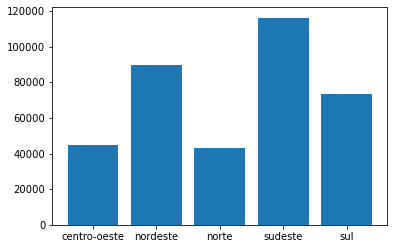

In [220]:
#exemplo de plotagem
import matplotlib.pyplot as plt

##MODELO: "SELECT colunas FROM tabela"

cur.execute("SELECT region, epidemiological_week, new_week_cases FROM regions_df")

regioes = []
semana_ep = []      #<----não está sendo usado no exemplo
novos_casos = []

dados = cur.fetchall() 
for linha in dados:
    regioes.append(linha[0])
    semana_ep.append(linha[1])     #<----não está sendo usado no exemplo
    novos_casos.append(linha[2])
    
plt.bar(regioes, novos_casos)
plt.show()

### CONSULTAS - modo visual (recomendado)
- Para conseguir visualizar diretamente o banco de dados (sem o python), entre em 'https://sqlitebrowser.org/dl/' e baixe o SqLite Browser. Nele é possível fazer consultas e conferência de dados. (essa aplicação é leve e confiável)
- Com o programa instalado, basta abrir o arquivo "indicadores.db" e depoir ir em "tabelas". Depois clique com o botão direito em uma delas e selecione a opção "navegar tabelas". Lá é possivel visualizar e filtar dados diretamente.

### CONSULTAS - por código
- Também é possível fazer solicitações específicas para o banco de dados diretamente por meio de instruções SQL. Abaixo há um exemplo que soma o total de habitantes da tabela de cidades para as cidades da região sudeste.

In [221]:
##Consultar soma de valores
##ALTERE esses valores para personalizar sua consulta

col = 'total_inhabitants'  ##Coluna que você quer somar
tabela = 'cities_df'       ##De qual tabela ela é
col_condicao = 'region'    ##Filtrar por alguma outra coluna 
condicao = 'sudeste'       ##Condição para filtrar

#executa instrução
pd.read_sql("select sum({}) from {} where {} = '{}' ".format(col, tabela, col_condicao, condicao), con )

,sum(total_inhabitants)
0,2.675357e+09
